C:\Users\Manuela\AppData\Local\Temp\ipykernel_1864\882282968.py:67: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=150, blit=False)


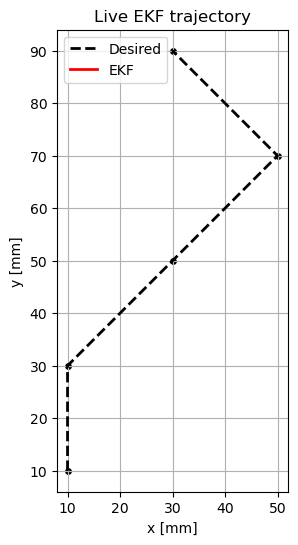

Connected: Node 30f587b4-fb96-452d-aa4f-57791877b058
i wait for variables
None
Waypoints (mm): [(10.0, 10.0), (10.0, 30.0), (50.0, 70.0), (30.0, 90.0)]
doing waypoint:
10.0 10.0
ekf results in move to pos:
0.0 0.0 0.0
motor left
184.29203673205103
motor right
215.70796326794897
ekf results in move to pos:
0.0 0.0 0.0
motor left
184.29203673205103
motor right
215.70796326794897
ekf results in move to pos:
0.0 0.0 0.0
motor left
184.29203673205103
motor right
215.70796326794897
ekf results in move to pos:
0.0 0.0 0.0
motor left
184.29203673205103
motor right
215.70796326794897
ekf results in move to pos:
0.0 0.0 0.0
motor left
184.29203673205103
motor right
215.70796326794897
ekf results in move to pos:
0.0 0.0 0.0
motor left
184.29203673205103
motor right
215.70796326794897
ekf results in move to pos:
0.0 0.0 0.0
motor left
184.29203673205103
motor right
215.70796326794897
ekf results in move to pos:
0.0 0.0 0.0
motor left
184.29203673205103
motor right
215.70796326794897
ekf results in

ValueError: too many values to unpack (expected 2)

In [6]:
from tdmclient import ClientAsync, aw
import math as m
import numpy as np
import asyncio
import matplotlib.pyplot as plt
from collections import deque
from matplotlib.animation import FuncAnimation

import importlib, Control_fromEKF
import Control_fromEKF
importlib.reload(Control_fromEKF)
from Control_fromEKF import follow_astar_path_ekf, get_cmd, grid_to_mm

import importlib, Filtering
import Filtering
importlib.reload(Filtering)
from Filtering import EKFState, ekf_task, motors_to_vw

from cv import get_robot
# params
Ts = 0.1  # time step in seconds
L = 95  # distance between wheels in mm
speed_to_mms = 0.3375  # conversion factor from thymio speed units to mm/s from solution ex.8 (in our measurement it was 0.43478260869565216)

# Process noise for EKF (tune) (from model-mismatch/random-walk/control execution)
q_proc = (
    1e-3, 1e-2, 1e-4,   # q_x, q_y, q_theta (model mismatch)
    75.72,  0.002692,         # q_v_ctrl, q_omega_ctrl (control execution noise)
    1e-2, 1e-5          # q_v_bias, q_omega_bias (random walk on v, omega)
)
# Camera measurement noise (tune)
r_cam = (1.435, 1.864, 0.001496)  # [mm^2, mm^2, rad^2]
r_mot = (75.72, 0.002692)    # motor noise on v, omega


# 1) buffers
traj = deque(maxlen=2000)   # (x,y)
path = [(0,0), (1,0), (2, 1), (3,2), (4,1)]  # grid cells
way_mm = grid_to_mm(path, cell_size_mm=20.0)
# EKF
ekf = EKFState(x0=[0,0,0,0,0], P0=1000*np.eye(5))
print(ekf)
ekf_traj = []
def ekf_get_state():
    s = ekf.get_state()  # (x,y,theta)
    ekf_traj.append((s[0], s[1], s[2]))  # log x,y each time it's called
    return s
# 3) live figure
fig, ax = plt.subplots(figsize=(6,6))
dxs, dys = zip(*way_mm)
line_des, = ax.plot(dxs, dys, 'k--', lw=2, label='Desired')
line_traj, = ax.plot([], [], 'r-', lw=2, label='EKF')
ax.scatter(dxs, dys, c='k', s=15)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x [mm]'); ax.set_ylabel('y [mm]')
ax.grid(True); ax.legend()
ax.set_title('Live EKF trajectory')

def update(_frame):
    if len(traj) >= 2:
        xs, ys = zip(*traj)
        line_traj.set_data(xs, ys)
        # optional: keep axes autoscaled around data
        ax.relim(); ax.autoscale_view()
    return (line_traj,)

ani = FuncAnimation(fig, update, interval=150, blit=False)
plt.show(block=False)  # non-blocking window

# start connect to Thymio
client = ClientAsync()
node = aw(client.wait_for_node())
try:
    aw(node.lock()) # lock the node for R/W
except Exception:
    pass # ignore it it wasn't locked

aw(node.stop())
print("Connected:", node)
print("i wait for variables")
motors = aw(node.wait_for_variables({"motor.left.speed","motor.right.speed"}))
print(motors)

# helper functions:
def get_motor_meas(): 
    # raw speeds in Thymio units (instantaneous)
    vl = int(node.v.motor.left.speed)
    vr = int(node.v.motor.right.speed)
    #print(vl, vr)
    # convert to v [mm/s], omega [rad/s] 
    v, w = motors_to_vw(vl, vr, speed_to_mms, L) 
    return np.array([v, w], dtype=float)

def get_cam_meas(image=None):
    # get position from camera
    if image is not None:
        pos, angle, __ = get_robot(image)
        return [pos, angle]
    return None

# start ekf in background
ekf_coro = ekf_task(ekf, client, node=node, Ts=Ts, speed_to_mms=speed_to_mms, L=L, q_proc=q_proc,
    r_cam=r_cam, r_mot=r_mot, get_cam_meas=None, get_motor_meas=get_motor_meas, get_cmd=get_cmd,
)
task = asyncio.create_task(ekf_coro)
try:
    x, y, th = aw(follow_astar_path_ekf(
        node=node, client=client, ekf_get_state=ekf_get_state,
        path_cells=path, cell_size_mm=20.0,
        use_smooth_vw=True,       # try smooth V–ω once EKF is stable
        v_cmd=200, kp_heading=20.0,
        dt=0.02, pos_tol=1.0, ang_tol=0.03
    ))
    print(f"Final pose (EKF): x={x:.1f} mm, y={y:.1f} mm, th={m.degrees(th):.1f} deg")
finally:
    task.cancel()
    aw(node.set_variables({"motor.left.target":[0], "motor.right.target":[0]}))
    aw(node.unlock())
    # plots
    # Build arrays
    if len(ekf_traj) > 1:
        xs, ys = zip(*ekf_traj)
    else:
        xs, ys = [], []

    dxs, dys = zip(*way_mm)

    plt.figure(figsize=(6,6))
    # desired path
    plt.plot(dxs, dys, 'k--', lw=2, label='Desired path (waypoints)')
    plt.scatter(dxs, dys, c='k', s=20)

    # actual path from EKF
    plt.plot(xs, ys, 'r-', lw=2, label='EKF trajectory')
    if xs and ys:
        plt.scatter([xs[0]],[ys[0]], c='g', s=40, label='Start (EKF)')
        plt.scatter([xs[-1]],[ys[-1]], c='r', s=40, label='End (EKF)')

    plt.axis('equal')
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    plt.title('Desired vs EKF trajectory')
    plt.legend()
    plt.grid(True)
    plt.show()

In [1]:
# to stop
# Simple motion test: drive forward 1 s, then stop
from tdmclient import ClientAsync, aw

client = ClientAsync()
node = aw(client.wait_for_node())     # connect via Thymio Suite (wireless dongle)
aw(node.lock())                       # take control
aw(node.stop())                       # stop any running program on the robot
print("Connected:", node)

try:
    # (Optional) ensure speed variables are available for later use
    #aw(node.wait_for_variables({"motors.left.speed", "motors.right.speed"}))

    # Command motors: forward 150 for 1 second, then stop
    aw(node.set_variables({"motor.left.target":[150], "motor.right.target":[150]}))
    aw(client.sleep(1.0))
    aw(node.set_variables({"motor.left.target":[0], "motor.right.target":[0]}))

finally:
    # Always release the robot
    aw(node.set_variables({"motor.left.target":[0], "motor.right.target":[0]}))
    aw(node.unlock())

KeyboardInterrupt: 